In [94]:
import pandas as pd
import numpy as np
from collections import Counter
from pprint import pprint

# network analysis libraries
import networkx as nx
from networkx.algorithms import bipartite as bi

# text processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia

# visualization librarires
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
% matplotlib inline

# settings
pd.options.mode.chained_assignment = None

In [95]:
twitter_data = pd.read_csv("auspol2019.csv", parse_dates = ['created_at', 'user_created_at'])

In [10]:
dt = twitter_data[["user_id", "id", "retweet_count", "favorite_count"]]

In [100]:
dt['user_id'] = dt['user_id'].apply(np.int64)

In [97]:
dt = dt.dropna()
dt.shape

(183370, 4)

In [101]:
dt.head()

,user_id,id,retweet_count,favorite_count
0,92484856,1130401208756187136,0.0,0.0
1,775647396,1130401205367140357,0.0,0.0
2,56873,1130401162782371841,0.0,0.0
3,908166034045026304,1130401143551434753,0.0,0.0
4,526007385,1130401118666809345,0.0,0.0


In [102]:
print("The dataset has", len(dt.user_id.unique()), "unique users.")
print("And", len(dt.id.unique()), "unique tweets.")
print("The tweet with the most retweets had", dt['retweet_count'].max(), "retweets.")
print("The tweet with the most favorites had", dt['favorite_count'].max(), "favorites.")

The dataset has 45862 unique users.
And 183370 unique tweets.
The tweet with the most retweets had 6622.0 retweets.
The tweet with the most favorites had 15559.0 favorites.


In [103]:
most_retweet_faves = twitter_data.loc[twitter_data["favorite_count"] == 15559.0]
print(most_retweet_faves.iloc[0][7], "user's tweet, <", most_retweet_faves.iloc[0][2], "> had the highest retweet and favorite counts.")

SaraCarterDC user's tweet, < Shocking defeat for Left in Australia, stunned pollsters and mainstream media who had predicted this election as 'unlosable for Labor'. Conservative @ScottMorrisonMP focused on 'Australian First', Jobs and Imigration, while Labor focused on #ClimateChange https://t.co/hFt7vgwuEd > had the highest retweet and favorite counts.


In [104]:
# create a graph
B = nx.Graph()

# add nodes with the node attribute "bipartite"
B.add_nodes_from(list(dt.user_id.values), bipartite=0)
B.add_nodes_from(list(dt.id.values), bipartite=1)

# add edges only between nodes of opposite node sets with weights
subset = dt[['user_id', 'id', 'retweet_count']]
edges_tuples = [tuple(x) for x in subset.values]
B.add_weighted_edges_from(edges_tuples)

In [105]:
max(nx.degree_centrality(B).values())

0.004087579777604251

In [106]:
nx.is_bipartite(B)

True

In [107]:
# trim edges function from the book 
def trim_edges(g, weight = 1):
    edges = []
    g2 = nx.Graph()
    for f, to, edata in g.edges(data = True):
        if edata['weight'] > weight:
            x = float(edata['weight'])
            edges.append((f, to, x))
    g2.add_weighted_edges_from(edges)
    return g2

# island method function from the book 
def island_method(g, iterations = 5):
    weights = [edata['weight'] for f, to, edata in g.edges(data = True)]
    mn = int(min(weights))
    mx = int(max(weights))
    step = int((mx - mn) / iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn, mx, step)]

In [132]:
# display thresholds
values = [['Threshold', 'Appearances']]
islands = island_method(B, iterations = 5)

for i in islands:
    threshold = i[0]
    num_people = len(i[1])
    temp_list = [threshold, num_people]
    values.append(temp_list)
    
headers = values.pop(0)
islan_df = pd.DataFrame(values, columns = headers)
islan_df

,Threshold,Appearances
0,0,78231
1,1324,39
2,2648,10
3,3972,2
4,5296,2
5,6620,2


In [131]:
user = bi.weighted_projected_graph(B, dt.user_id, ratio = False)

values = [['Threshold', 'Connection between Movies']]
islands = island_method(user, iterations = 5)

for i in islands:
    threshold = i[0]
    num_people = len(i[1])
    temp_list = [threshold, num_people]
    values.append(temp_list)
    
headers = values.pop(0)
islan_df = pd.DataFrame(values, columns = headers)
islan_df

ValueError: min() arg is an empty sequence

In [136]:
[edata['weight'] for f, to, edata in B.edges(data = True)]

[0.0,
 0.0,
 0.0,
 8.0,
 0.0,
 2.0,
 0.0,
 1.0,
 5.0,
 0.0,
 3.0,
 5.0,
 0.0,
 1.0,
 7.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 2.0,
 0.0,
 0.0,
 4.0,
 0.0,
 1.0,
 0.0,
 0.0,
 2.0,
 13.0,
 1.0,
 2.0,
 12.0,
 2.0,
 1.0,
 18.0,
 5.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 8.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.0,
 18.0,
 2.0,
 28.0,
 4.0,
 12.0,
 0.0,
 0.0,
 2.0,
 1.0,
 23.0,
 1.0,
 1.0,
 4.0,
 1.0,
 9.0,
 0.0,
 2.0,
 0.0,
 8.0,
 6.0,
 28.0,
 1.0,
 2.0,
 1.0,
 2.0,
 0.0,
 0.0,
 27.0,
 0.0,
 0.0,
 2.0,
 2.0,
 2.0,
 12.0,
 11.0,
 23.0,
 0.0,
 1.0,
 33.0,
 53.0,
 1.0,
 2.0,
 6.0,
 7.0,
 0.0,
 324.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 6.0,
 6.0,
 1.0,
 10.0,
 2.0,
 3.0,
 1.0,
 11.0,
 0.0,
 0.0,
 7.0,
 1.0,
 4.0,
 3.0,
 2.0,
 9.0,
 1.0,
 1.0,
 2.0,
 9.0,
 1.0,
 1.0,
 23.0,
 2.0,
 0.0,
 2.0,
 2.0,
 1.0,
 6.0,
 0.0,
 8.0,
 17.0,
 41.0,
 8.0,
 0.0,
 11.0,
 2.0,
 78.0,
 1.0,
 0.0,
 2.0,
 5.0,
 4.0,
 21.0,
 11.0,
 10.0,
 3.0,
 4

### Text Processing

In [96]:
# tweets
tweets = twitter_data[["full_text"]]
tweets.head()

,full_text
0,After the climate election: shellshocked green...
1,@narendramodi @smritiirani Coverage of indian ...
2,@workmanalice Do you know if Facebook is relea...
3,@vanbadham We all understand we have a compuls...
4,"Shares were mixed in Asia, with India and Aust..."


In [7]:
# remove usernames
tweets['tidy_tweet'] = tweets['full_text'].str.replace("@[A-Za-z0-9]+", "")

# remove urls 
tweets['tidy_tweet'] = tweets['tidy_tweet'].str.replace("https?://[A-Za-z0-9./]+", "")

# remove numbers and punctuations
tweets['tidy_tweet'] = tweets['tidy_tweet'].str.replace("[^a-zA-Z]", " ")

# lower case the text
tweets['tidy_tweet'] = tweets["tidy_tweet"].str.lower()

# tokenize the text
tweets['tidy_tweet'] = tweets['tidy_tweet'].apply(lambda x: x.split())

# remove stop words
stop_words = stopwords.words('english')
tweets['tidy_tweet'] = tweets['tidy_tweet'].apply(lambda x: [i for i in x if i not in stop_words])

# lemmatized words
lemma = nltk.WordNetLemmatizer()
tweets['tidy_tweet'] = tweets['tidy_tweet'].apply(lambda x: [lemma.lemmatize(i) for i in x])

# a copy of the words for visualization
hf_token = tweets['tidy_tweet'].copy()

# put it back together
tweets['tidy_tweet'] = tweets['tidy_tweet'].apply(lambda x: " ".join(x))

In [113]:
def tidy_tweet(text):
    stop_words = stopwords.words('english')
    lemma = nltk.WordNetLemmatizer()
    
    hastag = text.str.replace("#[A-Za-z0-9]+", "")
    username = hastag.str.replace("@[A-Za-z0-9]+", "")
    urls = username.str.replace("https?://[A-Za-z0-9./]+", "")
    num_punt = urls.str.replace("[^a-zA-Z]", " ")
    lower_case = num_punt.str.lower()
    token = lower_case.apply(lambda x: x.split())
    stop_words = token.apply(lambda x: [i for i in x if i not in stop_words])
    lemmad = stop_words.apply(lambda x: [lemma.lemmatize(i) for i in x])
    #clean = lemmad.apply(lambda x: " ".join(x))
    return lemmad


In [98]:
hf_token = tidy_tweet(tweets.full_text)

In [99]:
hf_token

0         [climate, election, shellshocked, green, group...
1         [coverage, indian, election, sb, tv, channel, ...
2         [know, facebook, releasing, election, post, mo...
3         [understand, compulsory, preference, system, v...
4         [share, mixed, asia, india, australia, leading...
5         [australia, pollster, review, incorrect, elect...
6         [disappointing, plibersek, ruled, leadership, ...
7         [feel, like, exact, thing, happens, australia,...
8         [quiet, australian, latest, upset, election, f...
9         [conservative, look, set, form, gov, australia...
10        [hear, bloody, hear, party, opposes, relentles...
11        [comment, losing, unlosable, election, afterma...
12        [conservative, look, set, form, gov, australia...
13        [australia, pollster, review, incorrect, elect...
14        [imo, people, care, enough, vote, without, coe...
15        [un, infografica, del, che, ci, aiuta, confron...
16        [investor, go, shopping, toast

In [100]:
# high frequency words
c = Counter()
for i in hf_token:
    c.update(i)
    
hf_words = pd.DataFrame(c.most_common(), columns = ["Word", "Count"])
hf_words.head(10)

,Word,Count
0,election,35402
1,australia,34189
2,vote,24221
3,labor,18521
4,amp,16082
5,party,11716
6,people,11483
7,australian,10938
8,get,9694
9,like,9505


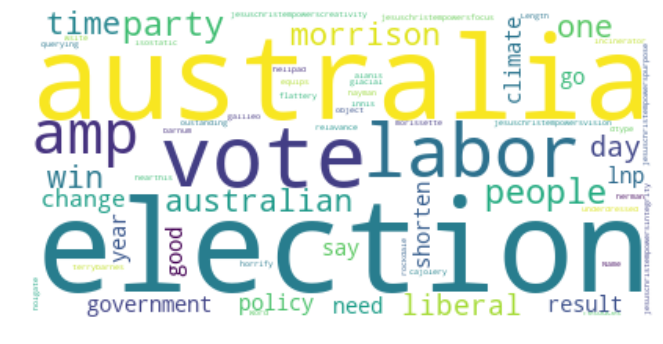

In [101]:
wordcloud = WordCloud(random_state=21, max_words = 100, max_font_size=110, background_color="white").generate(str(hf_words.Word))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

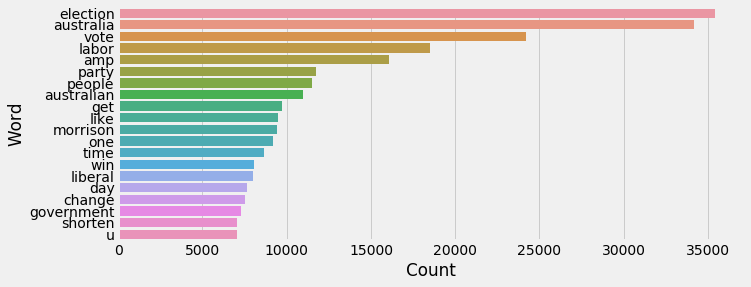

In [102]:
style.use('fivethirtyeight')


figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(10, 4)

sns.barplot(data=hf_words[:20], y="Word", x="Count", ax=ax)

In [104]:
sa = sia()
results = []
tidy_tweet = hf_token.apply(lambda x: " ".join(x))

for i in list(tidy_tweet):
    pol_score = sa.polarity_scores(i)
    pol_score['tweet'] = i
    results.append(pol_score)
    
sa_score = pd.DataFrame.from_records(results)
sa_score.head()

,compound,neg,neu,pos,tweet
0,0.2732,0.000,0.741,0.259,climate election shellshocked green group rema...
1,0.0000,0.000,1.000,0.000,coverage indian election sb tv channel austral...
2,-0.1531,0.169,0.704,0.127,know facebook releasing election post mortem a...
3,-0.2755,0.117,0.883,0.000,understand compulsory preference system vote g...
4,0.6808,0.000,0.699,0.301,share mixed asia india australia leading gain ...


In [105]:
sa_score['label'] = 0
sa_score.loc[sa_score['compound'] > 0.2, 'label'] = 1
sa_score.loc[sa_score['compound'] < -0.2, 'label'] = -1
sa_score.head()

,compound,neg,neu,pos,tweet,label
0,0.2732,0.000,0.741,0.259,climate election shellshocked green group rema...,1
1,0.0000,0.000,1.000,0.000,coverage indian election sb tv channel austral...,0
2,-0.1531,0.169,0.704,0.127,know facebook releasing election post mortem a...,0
3,-0.2755,0.117,0.883,0.000,understand compulsory preference system vote g...,-1
4,0.6808,0.000,0.699,0.301,share mixed asia india australia leading gain ...,1


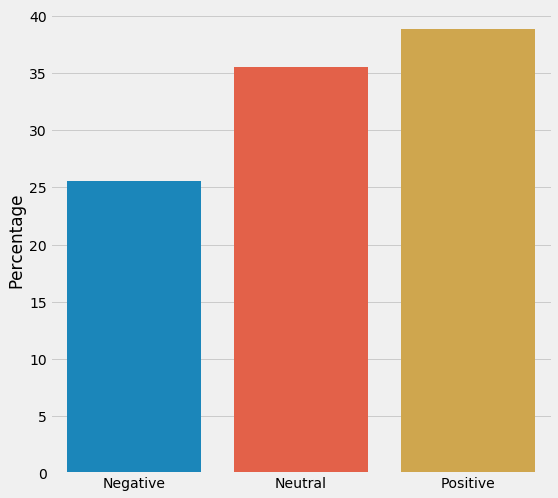

In [106]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = sa_score.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [116]:
pos_tweets = sa_score[sa_score.label == 1].tweet
pos_words = tidy_tweet(pos_tweets)

# high frequency words
c = Counter()
for i in pos_words:
    c.update(i)
    
posi_words = pd.DataFrame(c.most_common(), columns = ["Word", "Count"])
posi_words.head(10)

,Word,Count
0,election,15532
1,australia,15305
2,vote,11083
3,party,8710
4,labor,8068
5,amp,7331
6,win,6854
7,like,6513
8,good,5235
9,people,5068


In [117]:
pos_tweets = sa_score[sa_score.label == -1].tweet
pos_words = tidy_tweet(pos_tweets)

# high frequency words
c = Counter()
for i in pos_words:
    c.update(i)
    
negi_words = pd.DataFrame(c.most_common(), columns = ["Word", "Count"])
negi_words.head(10)

,Word,Count
0,australia,8644
1,election,8302
2,labor,5682
3,amp,5642
4,vote,5622
5,people,4165
6,australian,2976
7,get,2847
8,climate,2689
9,one,2579


In [118]:
posi_words[np.logical_not(posi_words.Word.isin(negi_words.Word))].head(10)

,Word,Count
355,seizes,454
493,celebrates,317
775,damien,202
1618,poised,83
2678,npr,44
2843,delighted,40
2958,wilt,38
3704,appreciated,26
3756,inspirational,26
3812,azerbaijan,25


In [119]:
negi_words[np.logical_not(negi_words.Word.isin(posi_words.Word))].head(10)

,Word,Count
2976,thinkprogress,28
3199,nonexistent,26
3428,jailed,23
3482,gloom,22
3652,laborout,21
3699,forecaster,20
3886,evades,19
4001,harassing,18
4017,uproar,18
4113,reek,17
